# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 139.9/139.9 kB ? eta 0:00:00
     --------------------------------------- 13.5/13.5 MB 50.4 MB/s eta 0:00:00
     ---------------------------------------- 84.4/84.4 kB 4.9 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

C:\Users\rlgus\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\rlgus/.cache\torch\hub\huggingface_pytorch-transformers_main


DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [2]:
# IMDB 감정 분석 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")


# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    max_len = 400  # 입력 문장의 최대 길이 설정
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    texts = torch.LongTensor(
        tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids
    )

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels


# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [3]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in C:\Users\rlgus/.cache\torch\hub\huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [4]:
from torch import nn


# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')

        # [CLS] 토큰 분류기 정의
        self.classifier = nn.Linear(768, 1)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(x)['last_hidden_state']

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])

        return x  # logit 출력


model = TextClassifier()

Using cache found in C:\Users\rlgus/.cache\torch\hub\huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [5]:
for param in model.encoder.parameters():
    param.requires_grad = False

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [6]:
def accuracy(model, dataloader):
    cnt = 0  # 전체 샘플 수
    acc = 0  # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 로짓(logit) 출력

        # 시그모이드는 생략 가능 (BCEWithLogitsLoss를 썼다면 threshold만 적용)
        # preds = torch.argmax(preds, dim=-1)
        preds = (preds > 0).long()[..., 0]

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

In [7]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# 학습 설정
lr = 0.001
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.BCEWithLogitsLoss()  # 이진 분류용 손실 함수

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 5

# 정확도 및 손실 추적을 위한 리스트
train_losses = []
train_accs = []
test_accs = []

# 학습 루프
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 학습 모드 설정

    for data in train_loader:
        model.zero_grad()  # 이전 gradient 초기화

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()  # GPU 이동 및 float 변환

        preds = model(inputs)[..., 0]  # 출력 차원 맞추기 (batch_size,)

        loss = loss_fn(preds, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        total_loss += loss.item()  # loss 누적

    train_losses.append(total_loss)
    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    # 평가 시 gradient 계산 비활성화
    with torch.no_grad():
        model.eval()  # 평가 모드로 전환 (계산 비활성화)
        train_acc = accuracy(model, train_loader)
        train_accs.append(train_acc)

        test_acc = accuracy(model, test_loader)
        test_accs.append(test_acc)

        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch   0 | Train Loss: 5.37998665869236
=========> Train acc: 1.000 | Test acc: 1.000
Epoch   1 | Train Loss: 0.755624333396554
=========> Train acc: 1.000 | Test acc: 1.000
Epoch   2 | Train Loss: 0.33039866108447313
=========> Train acc: 1.000 | Test acc: 1.000
Epoch   3 | Train Loss: 0.22262925002723932
=========> Train acc: 1.000 | Test acc: 1.000
Epoch   4 | Train Loss: 0.17024813126772642
=========> Train acc: 1.000 | Test acc: 1.000


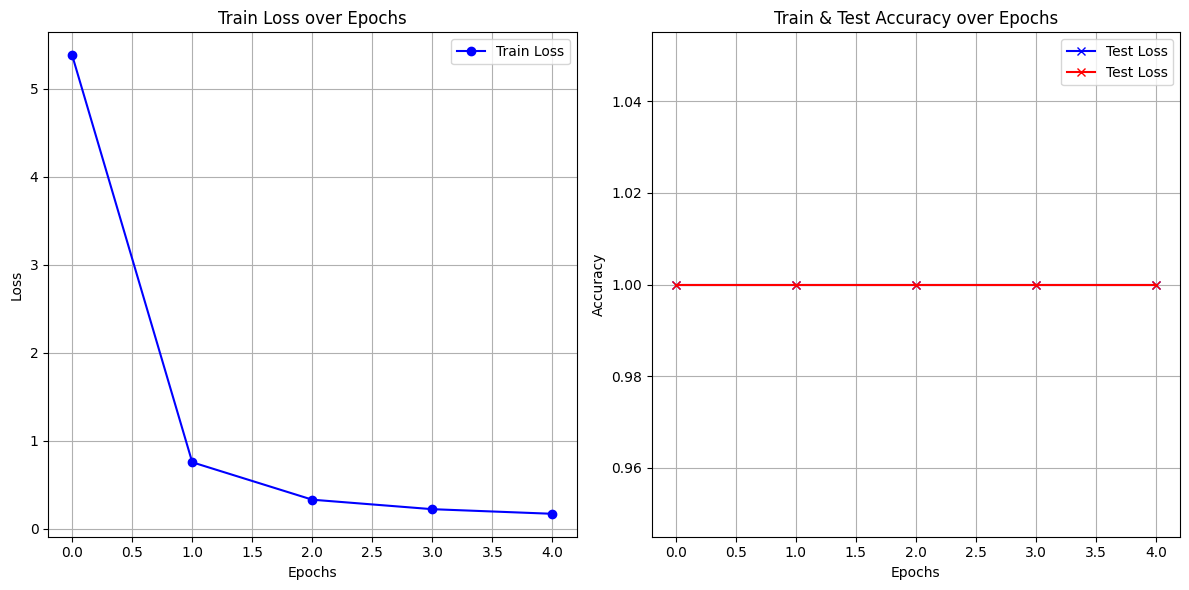

In [8]:
# 손실 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 첫 번째 그래프: Train Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', color='b')
plt.title('Train Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# 두 번째 그래프: Test Loss
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Test Loss', marker='x', color='b')
plt.plot(test_accs, label='Test Loss', marker='x', color='r')
plt.title('Train & Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()
